## Approach

1. Identify available dates and temporal frequency of observations for a given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the Land-Atmosphere Carbon Flux data product
2. Pass the STAC item into the raster API `/stac/tilejson.json` endpoint
3. Using `folium.plugins.DualMap`, visualize two tiles (side-by-side), allowing time point comparison
4. After the visualization, perform zonal statistics for a given polygon

## About the Data

This dataset presents a variety of carbon flux parameters derived from the Más Informada Carnegie-Ames-Stanford-Approach (MiCASA) model. The model’s input data includes air temperature, precipitation, incident solar radiation, a soil classification map, and several satellite derived products. All model calculations are driven by analyzed meteorological data from NASA’s Modern-Era Retrospective analysis for Research and Application, Version 2 (MERRA-2). The resulting product provides global, daily data at 0.1 degree resolution from January 2001 through December 2023. It includes carbon flux variables expressed in units of kilograms of carbon per square meter per day (kg Carbon/m²/day) from net primary production (NPP), heterotrophic respiration (Rh), wildfire emissions (FIRE), fuel wood burning emissions (FUEL), net ecosystem exchange (NEE), and net biosphere exchange (NBE). The latter two are derived from the first four (see Scientific Details below). MiCASA is an extensive revision of the CASA – Global Fire Emissions Database, version 3 (CASA-GFED3) product. CASA-GFED3 and earlier versions of MERRA-driven CASA-GFED carbon fluxes have been used in several atmospheric carbon dioxide (CO₂) transport studies, serve as a community standard for priors of flux inversion systems, and through the support of NASA’s Carbon Monitoring System (CMS), help characterize, quantify, understand and predict the evolution of global carbon sources and sinks.

For more information regarding this dataset, please visit the [U.S. Greenhouse Gas Center](https://earth.gov/ghgcenter).

# Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

## Query the STAC API
First, we are going to import the required libraries. Once imported, they allow better executing a query in the GHG Center Spatio Temporal Asset Catalog (STAC) Application Programming Interface (API) where the granules for this collection are stored.

In [1]:
# Import the following libraries
import requests
import folium
import folium.plugins
from folium import Map, TileLayer
from pystac_client import Client
import branca
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "http://ghg.center/api/stac"

# The RASTER API is used to fetch collections for visualization
RASTER_API_URL = "https://ghg.center/api/raster"

# The collection name is used to fetch the dataset from the STAC API. First, we define the collection name as a variable
# Name of the collection for MiCASA Land Carbon Flux
collection_name = "micasa-carbonflux-daygrid-v1"

# Next, we need to specify the asset name for this collection
# The asset name is referring to the raster band containing the pixel values for the parameter of interest
# For the case of the MiCASA Land Carbon Flux collection, the parameter of interest is “rh”
# rh = Heterotrophic Respiration
asset_name = "rh"

In [ ]:
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'requests' library allows a HTTP request possible
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()

# Print the properties of the collection to the console
collection

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2003 to December 2017. By looking at the `dashboard:time density`, we observe that the periodic frequency of these observations is monthly.

In [4]:
# Create a function that would search for a data collection in the US GHG Center STAC API

# First, we need to define the function
# The name of the function = "get_item_count"
# The argument that will be passed through the defined function = "collection_id"
def get_item_count(collection_id):
   
    # Set a counter for the number of items existing in the collection
    count = 0

    # Define the path to retrieve the granules (items) of the collection of interest (MiCASA Land Carbon Flux) in the STAC API
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"

    # Run a while loop to make HTTP requests until there are no more URLs associated with the collection in the STAC API
    while True:

        # Retrieve information about the granules by sending a "get" request to the STAC API using the defined collection path
        response = requests.get(items_url)

        # If the items do not exist, print an error message and quit the loop
        if not response.ok:
            print("error getting items")
            exit()

        # Return the results of the HTTP response as JSON
        stac = response.json()
       
        # Increase the "count" by the number of items (granules) returned in the response
        count += int(stac["context"].get("returned", 0))

        # Retrieve information about the next URL associated with the collection (MiCASA Land Carbon Flux) in the STAC API (if applicable)
        next = [link for link in stac["links"] if link["rel"] == "next"]

        # Exit the loop if there are no other URLs
        if not next:
            break
       
        # Ensure the information gathered by other STAC API links associated with the collection are added to the original path
        # "href" is the identifier for each of the tiles stored in the STAC API
        items_url = next[0]["href"]
        # temp = items_url.split('/')
        # temp.insert(3, 'ghgcenter')
        # temp.insert(4, 'api')
        # temp.insert(5, 'stac')
        # items_url = '/'.join(temp)

    # Return the information about the total number of granules found associated with the collection (MiCASA Land Carbon Flux)
    return count

In [5]:
# Apply the function created above "get_item_count" to the data collection
number_of_items = get_item_count(collection_name)

# Get the information about the number of granules found in the collection
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit=600").json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 600 items


In [ ]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items[0]

## Explore Changes in Carbon Flux Levels Using the Raster API
We will explore changes in the land atmosphere Carbon flux `Heterotrophic Respiration` and examine their impacts over time. We'll then visualize the outputs on a map using `folium`.

In [7]:
# Now we create a dictionary where the start datetime values for each granule is queried more explicitly by year and month (e.g., 2020-02)
items = {item["properties"]["datetime"][:10]: item for item in items}

Below, we are entering the minimum and maximum values to provide our upper and lower bounds in the `rescale_values`.

In [8]:
# Fetch the minimum and maximum values for rescaling
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

Now, we will pass the item id, collection name, asset name, and the `rescaling factor` to the `Raster API` endpoint. This step is done twice, once for December 2003 and again for December 2017, so that we can visualize each event independently.

In [9]:
# Choose a color for displaying the tiles
# Please refer to matplotlib library if you'd prefer choosing a different color ramp.
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "purd"

# Make a GET request to retrieve information for the date mentioned below
date1 = '2023-01-01'
date1_tile = requests.get(

    # Pass the collection name, collection date, and its ID
    # To change the year and month of the observed parameter, you can modify the "items['YYYY-MM-DD']" statement
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[date1]['collection']}&item={items[date1]['id']}"

    # Pass the asset name
    f"&assets={asset_name}"

    # Pass the color formula and colormap for custom visualization
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"

    # Pass the minimum and maximum values for rescaling
    f"&rescale={rescale_values['min']},{rescale_values['max']}",

# Return response in JSON format
).json()

# Print the properties of the retrieved granule to the console
date1_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=micasa-carbonflux-daygrid-v1&item=micasa-carbonflux-daygrid-v1-20230101&assets=rh&color_formula=gamma+r+1.05&colormap_name=purd&rescale=-0.32319876551628113%2C5.9415082931518555'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 179.99999999999994, 90.0],
 'center': [-2.842170943040401e-14, 0.0, 0]}

In [10]:
# Make a GET request to retrieve information for the date mentioned below
date2 = '2023-01-31'
date2_tile = requests.get(

    # Pass the collection name, collection date, and its ID
    # To change the year and month of the observed parameter, you can modify the "items['YYYY-MM-DD']" statement
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[date2]['collection']}&item={items[date2]['id']}"

    # Pass the asset name
    f"&assets={asset_name}"

    # Pass the color formula and colormap for custom visualization
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"

    # Pass the minimum and maximum values for rescaling
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 

# Return response in JSON format
).json()

# Print the properties of the retrieved granule to the console
date2_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=micasa-carbonflux-daygrid-v1&item=micasa-carbonflux-daygrid-v1-20230131&assets=rh&color_formula=gamma+r+1.05&colormap_name=purd&rescale=-0.32319876551628113%2C5.9415082931518555'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 179.99999999999994, 90.0],
 'center': [-2.842170943040401e-14, 0.0, 0]}

## Visualize Land-Atmosphere Carbon Flux (Heterotrophic Respiration)

In [11]:
# For this study we are going to compare the Rh level for date1 and date2 over the State of Texas 
# To change the location, you can simply insert the latitude and longitude of the area of your interest in the "location=(LAT, LONG)" statement
# For example, you can change the current statement "location=(31.9, -99.9)" to "location=(34, -118)" to monitor the Rh level in California instead of Texas

# Set initial zoom and center of map for CO₂ Layer
# 'folium.plugins' allows mapping side-by-side
map_ = folium.plugins.DualMap(location=(31.9, -99.9), zoom_start=6)


# Define the first map layer with Rh level for the tile fetched for date 1
# The TileLayer library helps in manipulating and displaying raster layers on a map
map_layer_date1 = TileLayer(
    tiles=date1_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer
    name=f"{date1} Rh Level", # Title for the layer
    overlay= True, # The layer can be overlaid on the map
    legendEnabled = True # Enable displaying the legend on the map
)

# Add the first layer to the Dual Map
map_layer_date1.add_to(map_.m1)


# Define the first map layer with Rh level for the tile fetched for date 2
map_layer_date2 = TileLayer(
    tiles=date2_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer
    name=f"{date2} RH Level", # Title for the layer
    overlay= True, # The layer can be overlaid on the map
    legendEnabled = True # Enable displaying the legend on the map
)

# Add the second layer to the Dual Map
map_layer_date2.add_to(map_.m2)

# Display data markers (titles) on both maps
folium.Marker((40, 5.0), tooltip="both").add_to(map_)

# Add a layer control to switch between map layers
folium.LayerControl(collapsed=False).add_to(map_)

# Add a legend to the dual map using the 'branca' library. 
# Note: the inserted legend is representing the minimum and maximum values for both tiles.
colormap = branca.colormap.linear.PuRd_09.scale(0, 0.3) # minimum value = 0, maximum value = 0.3 (kg Carbon/m2/daily)

# Classify the colormap according to specified Rh values 
colormap = colormap.to_step(index=[0, 0.07, 0.15, 0.22, 0.3])

# Add the data unit as caption
colormap.caption = 'Rh Values (kg Carbon/m2/daily)'

# Display the legend and caption on the map
colormap.add_to(map_.m1)

# Visualize the Dual Map
map_

# Calculate Zonal Statistics
To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas, United States.

In [12]:
# The Area of Interest (AOI) is set to Dallas, Texas (USA)
texas_dallas_aoi = {
    "type": "Feature", # Create a feature object
    "properties": {},
    "geometry": { # Set the bounding coordinates for the polygon
        "coordinates": [
            [
                # [longitude, latitude]
                [-96.1, 32.28],  # Southeast Bounding Coordinate
                [-96.1, 33.28],  # Northeast Bounding Coordinate
                [-97.58, 33.28], # Northwest Bounding Coordinate
                [-97.58, 32.28],  # Southwest Bounding Coordinate
                [-96.1, 32.28]   # Closing the polygon at the Southeast Bounding Coordinate
            ]
        ],
        "type": "Polygon",
    },
}

In [13]:
# Create a new map to display the generated polygon
aoi_map = Map(

    # Base map is set to OpenStreetMap
    tiles="OpenStreetMap",

    # Define the spatial properties for the map
    location=[
        32.81,-96.93, # coordinates for Dallas, Texas area
    ],

    # Set the zoom value
    zoom_start=9, # zoom in or out by increasing or decreasing the value here
)

# Insert the Dallas, TX polygon to the map
folium.GeoJson(texas_dallas_aoi, name="Texas, Dallas").add_to(aoi_map)

# Visualize the map
aoi_map

Before we generate stats for a specific item (observation), we first check the total number of items available within the collection and retrieve the information regarding their start datetime.

In [14]:
# Check the total number of items available within the collection
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 600 items


In [ ]:
# Examine the first item in the collection
items[0]

Now we need to develop a function that runs through the data collection and generates the statistics for a specific item (granule) within the boundaries of the AOI polygon.

In [16]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
# Create a function that retrieves information regarding a specific granule using its asset name and raster identifier and generates the statistics for it

# The function takes an item (granule) and a JSON (Dallas, TX polygon) as input parameters
def generate_stats(item, geojson):

    # A POST request is made to submit the data associated with the item of interest (specific observation) within the Dallas, TX boundaries to compute its statistics
    result = requests.post(

        # Raster API Endpoint for computing statistics
        f"{RASTER_API_URL}/cog/statistics",

        # Pass the URL to the item, asset name, and raster identifier as parameters
        params={"url": item["assets"][asset_name]["href"]},

        # Send the GeoJSON object (Dallas, TX polygon) along with the request
        json=geojson,

    # Return the response in JSON format
    ).json()

    # Print the result
    print(result)

    # Return a dictionary containing the computed statistics along with the item's datetime information
    return {
        **result["properties"],
        "datetime": item["properties"]["datetime"][:10],
    }

In [17]:
# Generate a for loop that iterates over all the existing items in the collection
for item in items:

    # The loop will then retrieve the information for the start datetime of each item in the list
    print(item["properties"]["datetime"])

    # Exit the loop after printing the start datetime for the first item in the collection
    break

2023-12-31T00:00:00+00:00


## Generate the statistics for the AOI

In [ ]:
%%time
# %%time = Wall time (execution time) for running the code below

# Generate statistics using the created function "generate_stats" within the bounding box defined by the "texas_dallas_aoi" polygon
stats = [generate_stats(item, texas_dallas_aoi) for item in items]

In [19]:
# Print the stats for the first item in the collection
stats[0]

{'statistics': {'b1': {'min': 0.11864250898361206,
   'max': 1.3311004638671875,
   'mean': 0.7455709838867187,
   'count': 150.0,
   'sum': 111.83564758300781,
   'std': 0.2550486573615515,
   'median': 0.7395486831665039,
   'majority': 0.11864250898361206,
   'minority': 0.11864250898361206,
   'unique': 150.0,
   'histogram': [[3.0, 4.0, 17.0, 22.0, 24.0, 29.0, 20.0, 18.0, 7.0, 6.0],
    [0.11864250898361206,
     0.23988831043243408,
     0.3611341118812561,
     0.48237988352775574,
     0.6036257147789001,
     0.7248715162277222,
     0.8461172580718994,
     0.9673630595207214,
     1.0886088609695435,
     1.2098547220230103,
     1.3311004638671875]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 150.0,
   'percentile_2': 0.24085583359003068,
   'percentile_98': 1.2310137295722965}},
 'datetime': '2023-12-31'}

Create a function that goes through every single item in the collection and populates their properties - including the minimum, maximum, and sum of their values - in a table.

In [20]:
# Create a function that converts statistics in JSON format into a pandas DataFrame
def clean_stats(stats_json) -> pd.DataFrame:

    # Normalize the JSON data
    df = pd.json_normalize(stats_json)

    # Replace the naming "statistics.b1" in the columns
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]

    # Set the datetime format
    df["date"] = pd.to_datetime(df["datetime"])

    # Return the cleaned format
    return df

# Apply the generated function on the stats data
df = clean_stats(stats)

# Display the stats for the first 5 granules in the collection in the table
# Change the value in the parenthesis to show more or a smaller number of rows in the table
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2023-12-31,0.118643,1.331100,0.745571,150.0,111.835648,0.255049,0.739549,0.118643,0.118643,150.0,"[[3.0, 4.0, 17.0, 22.0, 24.0, 29.0, 20.0, 18.0...",100.0,0.0,150.0,0.240856,1.231014,2023-12-31
1,2023-12-30,0.118560,1.329713,0.744604,150.0,111.690636,0.254805,0.738541,0.118560,0.118560,150.0,"[[3.0, 4.0, 17.0, 22.0, 24.0, 29.0, 20.0, 18.0...",100.0,0.0,150.0,0.240662,1.229237,2023-12-30
2,2023-12-29,0.118470,1.328249,0.743593,150.0,111.538979,0.254547,0.737490,0.118470,0.118470,150.0,"[[3.0, 4.0, 17.0, 22.0, 24.0, 29.0, 20.0, 19.0...",100.0,0.0,150.0,0.240456,1.227379,2023-12-29
3,2023-12-28,0.118373,1.326706,0.742537,150.0,111.380539,0.254277,0.736633,0.118373,0.118373,150.0,"[[3.0, 4.0, 17.0, 23.0, 23.0, 29.0, 20.0, 19.0...",100.0,0.0,150.0,0.240238,1.225439,2023-12-28
4,2023-12-27,0.118268,1.325084,0.741434,150.0,111.215126,0.253992,0.735755,0.118268,0.118268,150.0,"[[3.0, 4.0, 17.0, 23.0, 23.0, 29.0, 20.0, 19.0...",100.0,0.0,150.0,0.240007,1.223415,2023-12-27


## Visualize the Data as a Time Series
We can now explore the Heterotrophic Respiration time series (January 2003 -December 2017) available for the Dallas, Texas area. We can plot the data set using the code below:

Text(0.5, 1.0, 'Heterotrophic Respiration Values for Dallas, Texas (May 2022 to January 2024)')

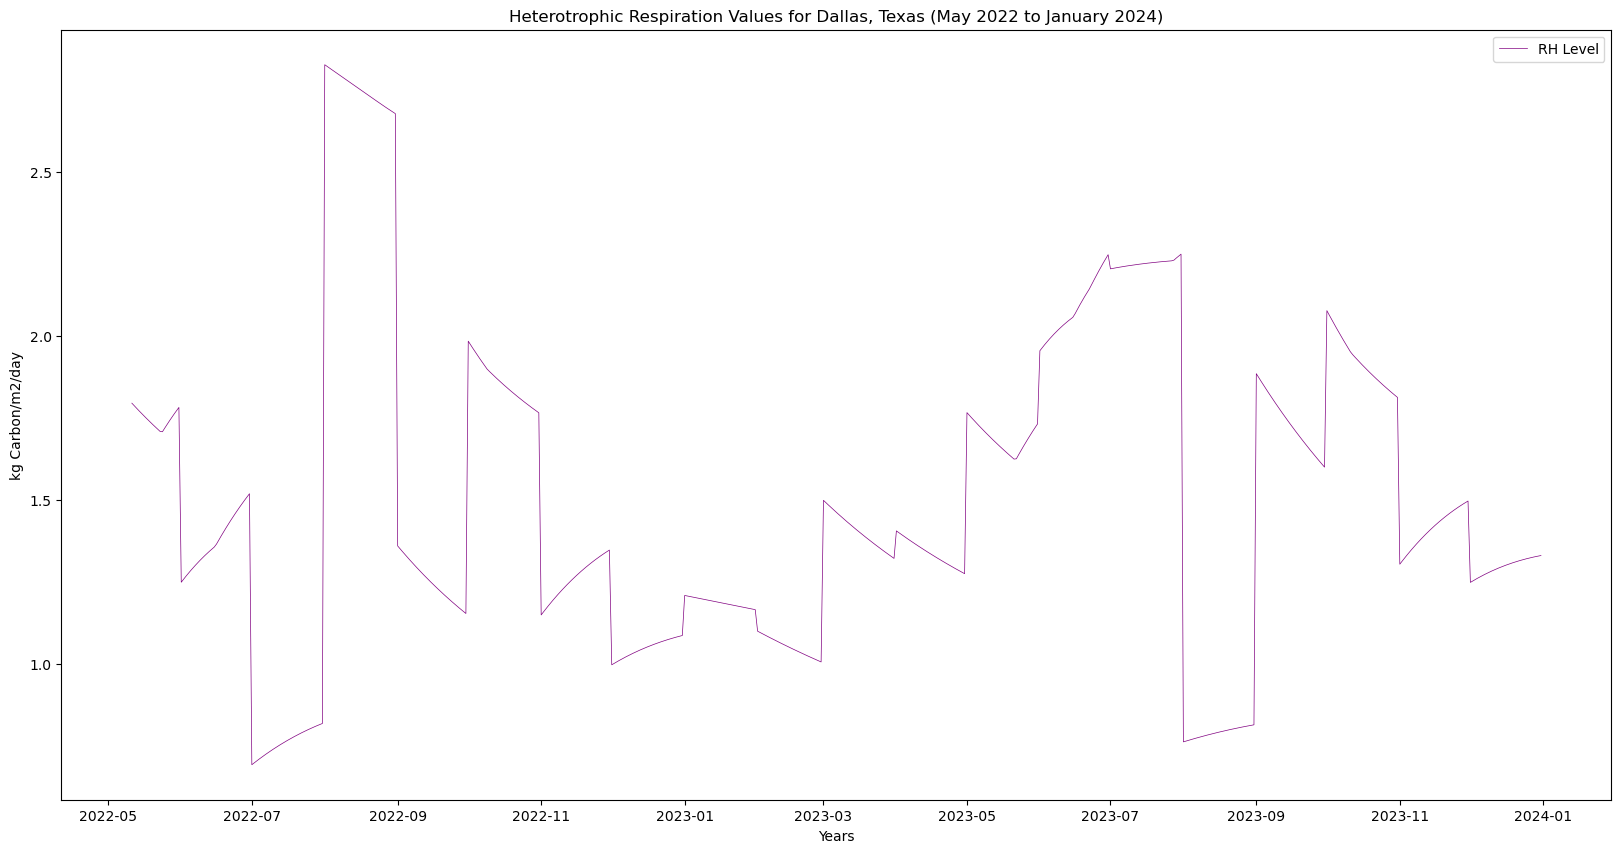

In [26]:
# Determine the width and height of the plot using the 'matplotlib' library
# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(20, 10)) 

# Plot the time series analysis of the daily Heterotrophic Respiration changes in Dallas, Texas
plt.plot(
    df["date"], # X-axis: date
    df["max"], # Y-axis: Rh value
    color="purple", # Line color
    linestyle="-", # Line style
    linewidth=0.5, # Line width
    label="RH Level", # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("kg Carbon/m2/day")

# Insert title for the plot
plt.title("Heterotrophic Respiration Values for Dallas, Texas (May 2022 to January 2024)")

To take a closer look at the daily Heterotrophic Respiration variability across this region, we are going to retrieve and display data collected during the October, 2017 observation.

In [22]:
# The 2013-12-29 observation is the 3rd item in the list
# Considering that a list starts with "0", we need to insert "2" in the "items[2]" statement
# Print the start Date Time of the third granule in the collection
print(items[2]["properties"]["datetime"]) 

2023-12-29T00:00:00+00:00


In [23]:
# A GET request is made for the October 2017 tile
october_tile = requests.get(

    # Pass the collection name, the item number in the list, and its ID
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[2]['collection']}&item={items[2]['id']}"

    # Pass the asset name
    f"&assets={asset_name}"

    # Pass the color formula and colormap for custom visualization
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"

    # Pass the minimum and maximum values for rescaling
    f"&rescale={rescale_values['min']},{rescale_values['max']}",

# Return the response in JSON format
).json()

# Print the properties of the retrieved granule to the console 
october_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=micasa-carbonflux-daygrid-v1&item=micasa-carbonflux-daygrid-v1-20231229&assets=rh&color_formula=gamma+r+1.05&colormap_name=purd&rescale=-0.32319876551628113%2C5.9415082931518555'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 179.99999999999994, 90.0],
 'center': [-2.842170943040401e-14, 0.0, 0]}

In [24]:
# Create a new map to display the Rh level for the Dallas, Texas area for the October, 2017 timeframe
aoi_map_bbox = Map(

    # Base map is set to OpenStreetMap
    tiles="OpenStreetMap",

    # Set the center of the map
    location=[
        32.8, # latitude
        -96.79, # longitude
    ],

    # Set the zoom value
    zoom_start=9,
)

# Define the map layer with the Rh level for October, 2017
map_layer = TileLayer(
    tiles=october_tile["tiles"][0], # Path to retrieve the tile

    # Set the attribution, transparency, and the title along with enabling the visualization of the legend on the map 
    attr="GHG", opacity = 0.7, name="October 2017 RH Level", overlay= True, legendEnabled = True
)

# Add the layer to the map
map_layer.add_to(aoi_map_bbox)

# Display data marker (title) on the map
folium.Marker((40, 5.9), tooltip="both").add_to(aoi_map_bbox)

# Add a layer control
folium.LayerControl(collapsed=False).add_to(aoi_map_bbox)

# Add a legend using the 'branca' library
colormap = branca.colormap.linear.PuRd_09.scale(0, 0.3) # minimum value = 0, maximum value = 0.3 (kg Carbon/m2/daily)

# Classify the colormap according to the specified Rh values
colormap = colormap.to_step(index=[0, 0.07, 0.15, 0.22, 0.3])

# Add the data unit as caption
colormap.caption = 'Rh Values (kg Carbon/m2/daily)'

# Display the legend and caption on the map
colormap.add_to(aoi_map_bbox)

# Visualize the map
aoi_map_bbox

## Summary

In this notebook we have successfully completed the following steps for the STAC collection for MiCASA Land Carbon Flux data:
1.	Install and import the necessary libraries 
2.	Fetch the collection from STAC collections using the appropriate endpoints
3.	Count the number of existing granules within the collection
4.	Map and compare the Heterotrophic Respiration (Rh) levels over the Dallas, Texas area for two distinctive years
5.	Create a table that displays the minimum, maximum, and sum of the Rh values for a specified region
6.	Generate a time-series graph of the Rh values for a specified region

If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform). 